# Using Clustering for Market Segmentation

A clustering problem is where you want to discover the inherent groupings in the data without knowing what the actual classes are.


   
   
Goal is to group objects into similar classes so that:
- intra-class similarity(distance) is high
- inter-class similarity(distance) is low

Hierarchical Clustering
- Agglomerative: starts with n clusters, then combines two most similar clusters, combines next two most similar clusters, and so on
- Divisive: opposite of agglomerative, goes from 1 to n clusters

Non-Hierarchical Clustering: choosing k initial clusters and reassign observations until no improvement can be obtained

K-Means
1. Randomly assign a number from, 1 to K, to each of the observations. These serve as initial cluster assignments for the observations.
2. Iterate until the cluster assignments stop changing:
   - For each of the K clusters, compute the cluster centroid. The kth cluster centroid is the vector of the p feature means for the observations in the kth cluster.
   - Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance.)
- Assumption 1: cluster center = arithmetic mean of all points belonging to the cluster; each cluster center is recalculated in the beginning of each new iteration
- Assumption 2: after cluster center has been recalculated, if given point is now closer to a different cluster center, then it is reassigned to the closer center



try cos distance

## Set-Up

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 1000)

### Import Data

In [2]:
# Read CSV to DataFrame
artists = pd.read_csv('Data/artists_train.csv')

# Drop unnamed column
artists.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

# Create id_name_genre column
#artists['id_name'] = artists['artist_id'] + ', ' + artists['artist_name'].fillna('None')

# Preview dataframe
print(artists.info())
artists.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194248 entries, 0 to 194247
Data columns (total 28 columns):
artist_id                  194248 non-null object
artist_name                191716 non-null object
artist_followers           194248 non-null float64
artist_popularity          194248 non-null float64
track_popularity_mean      194248 non-null float64
track_popularity_std       194248 non-null float64
track_release_year_mean    194248 non-null float64
track_release_year_std     194248 non-null float64
acousticness_mean          194248 non-null float64
acousticness_std           194248 non-null float64
danceability_mean          194248 non-null float64
danceability_std           194248 non-null float64
duration_ms_mean           194248 non-null float64
duration_ms_std            194248 non-null float64
energy_mean                194248 non-null float64
energy_std                 194248 non-null float64
instrumentalness_mean      194248 non-null float64
instrumentalness_std    

,artist_id,artist_name,artist_followers,artist_popularity,track_popularity_mean,track_popularity_std,track_release_year_mean,track_release_year_std,acousticness_mean,acousticness_std,danceability_mean,danceability_std,duration_ms_mean,duration_ms_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,liveness_mean,liveness_std,loudness_mean,loudness_std,speechiness_mean,speechiness_std,tempo_mean,tempo_std,valence_mean,valence_std
0,2jTsRGHAvKXXSbeO52G1t5,Webbstur,3453.0,28.0,17.8,10.195860,2017.3,0.948683,0.170563,0.255500,0.5925,0.116009,245121.3,51594.498027,0.84040,0.086234,0.413950,0.373703,0.15339,0.093559,-6.7449,1.570696,0.04442,0.015108,124.9970,2.174399,0.42026,0.266024
1,5CRw2KQzb9aH8HuyuQ6QCL,Ozy,103.0,6.0,2.5,5.233439,2012.7,4.001389,0.197861,0.354064,0.6189,0.177373,267232.6,94528.177818,0.72450,0.278383,0.672460,0.294077,0.21175,0.136774,-9.2551,5.195449,0.09468,0.055908,148.4241,21.335355,0.44111,0.272943
2,11fxyJpCpCnuG2c6NMuZNt,Bia Macedo,5177.0,11.0,7.8,4.391912,2017.0,0.000000,0.262620,0.159743,0.6322,0.087031,180036.6,12755.167904,0.87670,0.123941,0.000000,0.000000,0.37700,0.226577,-2.9268,2.288700,0.12018,0.090222,153.8066,20.089296,0.77540,0.090969
3,0pRBqfB42iVqXKIFJdfFKS,Brett Detar,1781.0,20.0,14.1,7.752419,2011.8,1.549193,0.183107,0.270250,0.4248,0.128387,259215.9,49391.796063,0.66320,0.200920,0.072125,0.140028,0.22184,0.176418,-7.4456,2.286342,0.03678,0.017357,135.1359,29.490275,0.48690,0.269610
4,5MpELOfAiq7aIBTij30phD,Harry James,17750.5,53.0,34.7,9.894709,1977.8,31.701901,0.841900,0.158289,0.4435,0.140408,197270.7,38825.948564,0.24639,0.198372,0.267144,0.373276,0.18035,0.086693,-12.8619,4.617813,0.03994,0.018269,100.5924,21.342652,0.40420,0.173864


### Define X

In [ ]:
X_train = artists.drop(columns=['artist_id', 'artist_name'])

### Normalize Data

#### Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_sscaled = ss.fit_transform(X_train)
X_train_sscaled = pd.DataFrame(X_train_sscaled, columns=X_train.columns)

#### MinMax Scaler

In [3]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_mmscaled = mms.fit_transform(X_train)
X_train_mmscaled = pd.DataFrame(X_train_mmscaled, columns=X_train.columns)

## K-Means Clustering

### K-Means (Unscaled)

#### K=3

In [13]:
# K-Means in SKLearn
k_means_3 = KMeans(n_clusters=3)
k_means_3.fit(X_train)
yhat_3 = k_means_3.predict(X_train)

In [37]:
# Silhouette Score
#labels_3 = k_means_3.labels_
sil_sc_3 = silhouette_score(X_train, yhat_3, metric='euclidean')
sil_sc_3

0.9612108913812986

In [16]:
# Calinski Harabasz Score
ch_sc_3 = calinski_harabasz_score(X_train, yhat_3)
ch_sc_3

157264.94188288614


#### K=4

In [20]:
# K-Means in SKLearn
k_means_4 = KMeans(n_clusters=4)
k_means_4.fit(X_train)
yhat_4 = k_means_4.predict(X_train)

In [38]:
# Silhouette Score
#labels_4 = k_means_4.labels_
sil_sc_4 = silhouette_score(X_train, yhat_4, metric='euclidean')
sil_sc_4

0.9489296016263137

In [21]:
# Calinski Harabasz Score
ch_sc_4 = calinski_harabasz_score(X_train, yhat_4)
ch_sc_4

151618.03217560623


#### K=5

In [22]:
# K-Means in SKLearn
k_means_5 = KMeans(n_clusters=5)
k_means_5.fit(X_train)
yhat_5 = k_means_5.predict(X_train)

In [39]:
# Silhouette Score
#labels_5 = k_means_5.labels_
sil_sc_5 = silhouette_score(X_train, yhat_5, metric='euclidean')
sil_sc_5

0.9011829362566631

In [23]:
# Calinski Harabasz Score
ch_sc_5 = calinski_harabasz_score(X_train, yhat_5)
ch_sc_5

165799.13265178702


#### K=6

In [24]:
# K-Means in SKLearn
k_means_6 = KMeans(n_clusters=6)
k_means_6.fit(X_train)
yhat_6 = k_means_6.predict(X_train)

In [40]:
# Silhouette Score
#labels_6 = k_means_6.labels_
sil_sc_6 = silhouette_score(X_train, yhat_6, metric='euclidean')
sil_sc_6

0.9005677037999094

In [25]:
# Calinski Harabasz Score
ch_sc_6 = calinski_harabasz_score(X_train, yhat_6)
ch_sc_6

171269.47846653475


#### K=10

In [26]:
# K-Means in SKLearn
k_means_10 = KMeans(n_clusters=10)
k_means_10.fit(X_train)
yhat_10 = k_means_10.predict(X_train)

In [41]:
# Silhouette Score
#labels_10 = k_means_10.labels_
sil_sc_10 = silhouette_score(X_train, yhat_10, metric='euclidean')
sil_sc_10

0.5010848006215459

In [27]:
# Calinski Harabasz Score
ch_sc_10 = calinski_harabasz_score(X_train, yhat_10)
ch_sc_10

204699.18778517135


#### K=15

In [28]:
# K-Means in SKLearn
k_means_15 = KMeans(n_clusters=15)
k_means_15.fit(X_train)
yhat_15 = k_means_15.predict(X_train)

In [42]:
# Silhouette Score
#labels_15 = k_means_15.labels_
sil_sc_15 = silhouette_score(X_train, yhat_15, metric='euclidean')
sil_sc_15

0.3503218202911173

In [29]:
# Calinski Harabasz Score
ch_sc_15 = calinski_harabasz_score(X_train, yhat_15)
ch_sc_15

228311.27475159423


#### K=20

In [30]:
# K-Means in SKLearn
k_means_20 = KMeans(n_clusters=20)
k_means_20.fit(X_train)
yhat_20 = k_means_20.predict(X_train)

In [43]:
# Silhouette Score
#labels_20 = k_means_20.labels_
sil_sc_20 = silhouette_score(X_train, yhat_20, metric='euclidean')
sil_sc_20

0.3282035435702609

In [31]:
# Calinski Harabasz Score
ch_sc_20 = calinski_harabasz_score(X_train, yhat_20)
ch_sc_20

251683.23809260657


#### K=50

In [32]:
# K-Means in SKLearn
k_means_50 = KMeans(n_clusters=50)
k_means_50.fit(X_train)
yhat_50 = k_means_50.predict(X_train)

In [44]:
# Silhouette Score
#labels_50 = k_means_50.labels_
sil_sc_50 = silhouette_score(X_train, yhat_50, metric='euclidean')
sil_sc_50

0.30120239185421593

In [33]:
# Calinski Harabasz Score
ch_sc_50 = calinski_harabasz_score(X_train, yhat_50)
ch_sc_50

301895.1531959279


#### K=100

In [34]:
# K-Means in SKLearn
k_means_100 = KMeans(n_clusters=100)
k_means_100.fit(X_train)
yhat_100 = k_means_100.predict(X_train)

In [45]:
# Silhouette Score
#labels_100 = k_means_100.labels_
sil_sc_100 = silhouette_score(X_train, yhat_100, metric='euclidean')
sil_sc_100

0.29860184120076216

In [36]:
# Calinski Harabasz Score
ch_sc_100 = calinski_harabasz_score(X_train, yhat_100)
ch_sc_100

331618.48450482957


#### Finding Optimal K

In [46]:
k_values = [3, 4, 5, 6, 10, 15, 20, 50, 100]

In [47]:
#[0.9612, 0.9489, 0.9012, 0.9006, 0.5011, 0.3503, 0.3282, 0.3012, 0.2986]
silhouette_scores = [sil_sc_3, 
                     sil_sc_4, 
                     sil_sc_5, 
                     sil_sc_6, 
                     sil_sc_10, 
                     sil_sc_15, 
                     sil_sc_20, 
                     sil_sc_50, 
                     sil_sc_100]
silhouette_scores

In [48]:
#[157264.94, 151618.03, 165799.13, 171269.48, 204699.19, 228311.27, 251683.24, 301895.15, 331618.48]
calinski_harabasz_scores = [ch_sc_3, 
                            ch_sc_4, 
                            ch_sc_5, 
                            ch_sc_6, 
                            ch_sc_10, 
                            ch_sc_15, 
                            ch_sc_20, 
                            ch_sc_50, 
                            ch_sc_100]
calinski_harabasz_scores

In [49]:
len(k_values) == len(silhouette_scores) == len(calinski_harabasz_scores)

True

##### Elbow Plot: Silhouette Scores

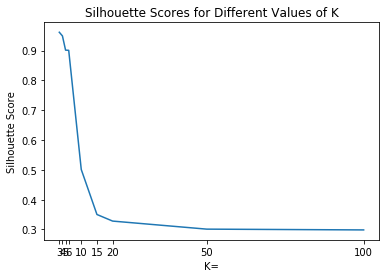

In [57]:
plt.plot(k_values, silhouette_scores)
plt.xticks(k_values)
plt.title("Silhouette Scores for Different Values of K")
plt.ylabel("Silhouette Score")
plt.xlabel("K=")
plt.show()

##### Elbow Plot: Calinski Harabaz Scores

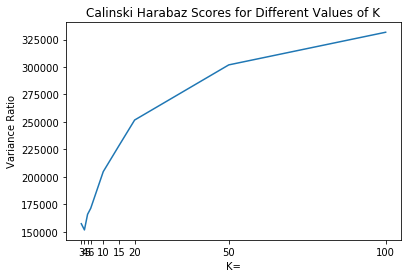

In [58]:
plt.plot(k_values, calinski_harabasz_scores)
plt.xticks(k_values)
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

### K-Means (Standard Scaler)

#### Testing Different K Values

##### K=3

In [61]:
# K-Means in SKLearn
k_means_3_ss = KMeans(n_clusters=3)
k_means_3_ss.fit(X_train_sscaled)
yhat_3_ss = k_means_3_ss.predict(X_train_sscaled)

# Silhouette Score
sil_sc_3_ss = silhouette_score(X_train_sscaled, yhat_3_ss, metric='euclidean')
sil_sc_3_ss

# Calinski Harabasz Score
ch_sc_3_ss = calinski_harabasz_score(X_train_sscaled, yhat_3_ss)
ch_sc_3_ss

In [62]:
# Silhouette Score
#labels_3 = k_means_3.labels_
sil_sc_3 = silhouette_score(X_train_sscaled, yhat_3, metric='euclidean')
sil_sc_3

0.12633466503322371

In [63]:
# Calinski Harabasz Score
ch_sc_3 = calinski_harabasz_score(X_train_sscaled, yhat_3)
ch_sc_3

22682.528626599502

##### K=4

In [ ]:
# K-Means in SKLearn
k_means_4_ss = KMeans(n_clusters=4)
k_means_4_ss.fit(X_train_sscaled)
yhat_4_ss = k_means_4_ss.predict(X_train_sscaled)

# Silhouette Score
sil_sc_4_ss = silhouette_score(X_train_sscaled, yhat_4_ss, metric='euclidean')
sil_sc_4_ss

# Calinski Harabasz Score
ch_sc_4_ss = calinski_harabasz_score(X_train_sscaled, yhat_4_ss)
ch_sc_4_ss

In [64]:
# K-Means in SKLearn
k_means_4 = KMeans(n_clusters=4)
k_means_4.fit(X_train_sscaled)
yhat_4 = k_means_4.predict(X_train_sscaled)

In [65]:
# Silhouette Score
#labels_4 = k_means_4.labels_
sil_sc_4 = silhouette_score(X_train_sscaled, yhat_4, metric='euclidean')
sil_sc_4

0.11120727123436948

In [66]:
# Calinski Harabasz Score
ch_sc_4 = calinski_harabasz_score(X_train_sscaled, yhat_4)
ch_sc_4

20716.146350968957

##### K=5

In [ ]:
# K-Means in SKLearn
k_means_5_ss = KMeans(n_clusters=5)
k_means_5_ss.fit(X_train_sscaled)
yhat_5_ss = k_means_5_ss.predict(X_train_sscaled)

# Silhouette Score
sil_sc_5_ss = silhouette_score(X_train_sscaled, yhat_5_ss, metric='euclidean')
sil_sc_5_ss

# Calinski Harabasz Score
ch_sc_5_ss = calinski_harabasz_score(X_train_sscaled, yhat_5_ss)
ch_sc_5_ss

In [67]:
# K-Means in SKLearn
k_means_5 = KMeans(n_clusters=5)
k_means_5.fit(X_train_sscaled)
yhat_5 = k_means_5.predict(X_train_sscaled)

In [68]:
# Silhouette Score
#labels_5 = k_means_5.labels_
sil_sc_5 = silhouette_score(X_train_sscaled, yhat_5, metric='euclidean')
sil_sc_5

0.10162697542915378

In [69]:
# Calinski Harabasz Score
ch_sc_5 = calinski_harabasz_score(X_train_sscaled, yhat_5)
ch_sc_5

18471.506952948366

##### K=6

In [70]:
# K-Means in SKLearn
k_means_6 = KMeans(n_clusters=6)
k_means_6.fit(X_train_sscaled)
yhat_6 = k_means_6.predict(X_train_sscaled)

In [71]:
# Silhouette Score
#labels_6 = k_means_6.labels_
sil_sc_6 = silhouette_score(X_train_sscaled, yhat_6, metric='euclidean')
sil_sc_6

0.10629562247376065

In [72]:
# Calinski Harabasz Score
ch_sc_6 = calinski_harabasz_score(X_train_sscaled, yhat_6)
ch_sc_6

17197.10950590829

##### K=10

In [73]:
# K-Means in SKLearn
k_means_10 = KMeans(n_clusters=10)
k_means_10.fit(X_train_sscaled)
yhat_10 = k_means_10.predict(X_train_sscaled)

In [74]:
# Silhouette Score
#labels_10 = k_means_10.labels_
sil_sc_10 = silhouette_score(X_train_sscaled, yhat_10, metric='euclidean')
sil_sc_10

0.09905222377768459

In [75]:
# Calinski Harabasz Score
ch_sc_10 = calinski_harabasz_score(X_train_sscaled, yhat_10)
ch_sc_10

14260.712850269503

##### K=15

In [76]:
# K-Means in SKLearn
k_means_15 = KMeans(n_clusters=15)
k_means_15.fit(X_train_sscaled)
yhat_15 = k_means_15.predict(X_train_sscaled)

In [77]:
# Silhouette Score
#labels_15 = k_means_15.labels_
sil_sc_15 = silhouette_score(X_train_sscaled, yhat_15, metric='euclidean')
sil_sc_15

0.08332137341241151

In [78]:
# Calinski Harabasz Score
ch_sc_15 = calinski_harabasz_score(X_train_sscaled, yhat_15)
ch_sc_15

11397.965515756572

##### K=20

In [79]:
# K-Means in SKLearn
k_means_20 = KMeans(n_clusters=20)
k_means_20.fit(X_train_sscaled)
yhat_20 = k_means_20.predict(X_train_sscaled)

In [80]:
# Silhouette Score
#labels_20 = k_means_20.labels_
sil_sc_20 = silhouette_score(X_train_sscaled, yhat_20, metric='euclidean')
sil_sc_20

0.08464213728362414

In [81]:
# Calinski Harabasz Score
ch_sc_20 = calinski_harabasz_score(X_train_sscaled, yhat_20)
ch_sc_20

9787.15262813311

##### K=50

In [82]:
# K-Means in SKLearn
k_means_50 = KMeans(n_clusters=50)
k_means_50.fit(X_train_sscaled)
yhat_50 = k_means_50.predict(X_train_sscaled)

In [83]:
# Silhouette Score
#labels_50 = k_means_50.labels_
sil_sc_50 = silhouette_score(X_train_sscaled, yhat_50, metric='euclidean')
sil_sc_50

0.07121974440629723

In [84]:
# Calinski Harabasz Score
ch_sc_50 = calinski_harabasz_score(X_train_sscaled, yhat_50)
ch_sc_50

5658.640260264468

##### K=100

In [85]:
# K-Means in SKLearn
k_means_100 = KMeans(n_clusters=100)
k_means_100.fit(X_train_sscaled)
yhat_100 = k_means_100.predict(X_train_sscaled)

In [86]:
# Silhouette Score
#labels_100 = k_means_100.labels_
sil_sc_100 = silhouette_score(X_train_sscaled, yhat_100, metric='euclidean')
sil_sc_100

0.06056694403649478

In [87]:
# Calinski Harabasz Score
ch_sc_100 = calinski_harabasz_score(X_train_sscaled, yhat_100)
ch_sc_100

3525.2142930442096

#### Finding Optimal K

In [88]:
k_values = [3, 4, 5, 6, 10, 15, 20, 50, 100]

In [89]:
#[0.9612, 0.9489, 0.9012, 0.9006, 0.5011, 0.3503, 0.3282, 0.3012, 0.2986]
silhouette_scores = [sil_sc_3, 
                     sil_sc_4, 
                     sil_sc_5, 
                     sil_sc_6, 
                     sil_sc_10, 
                     sil_sc_15, 
                     sil_sc_20, 
                     sil_sc_50, 
                     sil_sc_100]
silhouette_scores

[0.12633466503322371,
 0.11120727123436948,
 0.10162697542915378,
 0.10629562247376065,
 0.09905222377768459,
 0.08332137341241151,
 0.08464213728362414,
 0.07121974440629723,
 0.06056694403649478]

[22682.528626599502,
 20716.146350968957,
 18471.506952948366,
 17197.10950590829,
 14260.712850269503,
 11397.965515756572,
 9787.15262813311,
 5658.640260264468,
 3525.2142930442096]

In [91]:
len(k_values) == len(silhouette_scores) == len(calinski_harabasz_scores)

True

#### Silhouette Scores

when tight, close to 1; if not tight, close to -1

1. Plot Silhouette Score for different K values, calculated using:
   - 1) average distance between one data sample and all other points in the same cluster and 
   - 2) average distance between one data sample and all other points in the next nearest cluster
2. Pick K value closest to 1
   - higher score means model with better defined clusters
   

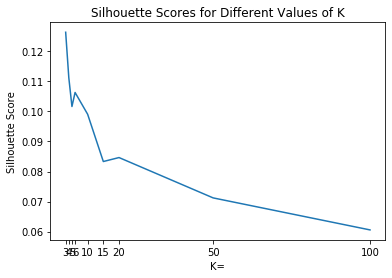

In [92]:
plt.plot(k_values, silhouette_scores)
plt.xticks(k_values)
plt.title("Silhouette Scores for Different Values of K")
plt.ylabel("Silhouette Score")
plt.xlabel("K=")
plt.show()

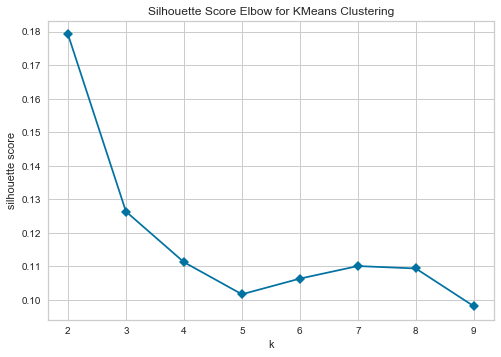

In [7]:
# Instantiate the clustering model and visualizer
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(2,10),
                              metric='silhouette', 
                              timings=False, 
                              locate_elbow=True)

visualizer.fit(X_train_sscaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Calinski Harabaz Scores

Calinski Harabaz Scores: (evaluates cluster fitness, also called variance ratio) evaluates variance of points in a cluster
- want intra-cluster variance to be low (suggesting that the clusters are tightly knit) 
- want inter-cluster variance to be high (suggesting that there is little to no ambiguity about which cluster the points belong to)
- the higher the score, the better the fit / better defined clusters


Elbow Plot: 
- higher scores aren't always better
- higher values of K introduce more overall complexity
- we choose the elbow because after it, the metric we are trying to optimize for gets better at a much slower rate (dealing with more clusters when fit is only slightly better isn't worth it)

In [ ]:
#[157264.94, 151618.03, 165799.13, 171269.48, 204699.19, 228311.27, 251683.24, 301895.15, 331618.48]
calinski_harabasz_scores = [ch_sc_3, 
                            ch_sc_4, 
                            ch_sc_5, 
                            ch_sc_6, 
                            ch_sc_10, 
                            ch_sc_15, 
                            ch_sc_20, 
                            ch_sc_50, 
                            ch_sc_100]
calinski_harabasz_scores

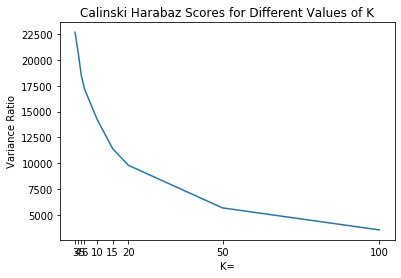

In [93]:
plt.plot(k_values, calinski_harabasz_scores)
plt.xticks(k_values)
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

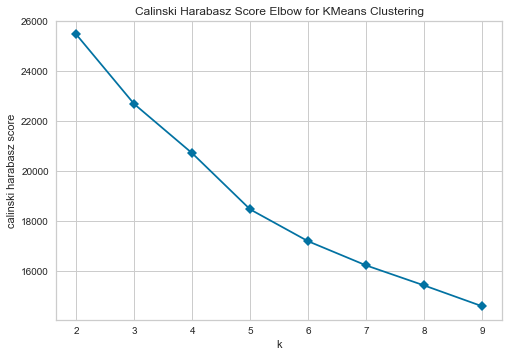

In [6]:
# Instantiate the clustering model and visualizer
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz', timings=False, locate_elbow=True)

visualizer.fit(X_train_sscaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## K-Means (MinMax Scaler)

### K=3

In [94]:
# K-Means in SKLearn
k_means_3 = KMeans(n_clusters=3)
k_means_3.fit(X_train_mmscaled)
yhat_3 = k_means_3.predict(X_train_mmscaled)

In [95]:
# Silhouette Score
#labels_3 = k_means_3.labels_
sil_sc_3 = silhouette_score(X_train_mmscaled, yhat_3, metric='euclidean')
sil_sc_3

0.21253858991563226

In [96]:
# Calinski Harabasz Score
ch_sc_3 = calinski_harabasz_score(X_train_mmscaled, yhat_3)
ch_sc_3

52094.04786468934

### K=4

In [97]:
# K-Means in SKLearn
k_means_4 = KMeans(n_clusters=4)
k_means_4.fit(X_train_mmscaled)
yhat_4 = k_means_4.predict(X_train_mmscaled)

In [98]:
# Silhouette Score
#labels_4 = k_means_4.labels_
sil_sc_4 = silhouette_score(X_train_mmscaled, yhat_4, metric='euclidean')
sil_sc_4

0.18594690842473538

In [99]:
# Calinski Harabasz Score
ch_sc_4 = calinski_harabasz_score(X_train_mmscaled, yhat_4)
ch_sc_4

44309.8644439604

### K=5

In [100]:
# K-Means in SKLearn
k_means_5 = KMeans(n_clusters=5)
k_means_5.fit(X_train_mmscaled)
yhat_5 = k_means_5.predict(X_train_mmscaled)

In [101]:
# Silhouette Score
#labels_5 = k_means_5.labels_
sil_sc_5 = silhouette_score(X_train_mmscaled, yhat_5, metric='euclidean')
sil_sc_5

0.15184148892035973

In [102]:
# Calinski Harabasz Score
ch_sc_5 = calinski_harabasz_score(X_train_mmscaled, yhat_5)
ch_sc_5

38863.363060324664

### K=6

In [103]:
# K-Means in SKLearn
k_means_6 = KMeans(n_clusters=6)
k_means_6.fit(X_train_mmscaled)
yhat_6 = k_means_6.predict(X_train_mmscaled)

In [104]:
# Silhouette Score
#labels_6 = k_means_6.labels_
sil_sc_6 = silhouette_score(X_train_mmscaled, yhat_6, metric='euclidean')
sil_sc_6

0.15553311520404833

In [105]:
# Calinski Harabasz Score
ch_sc_6 = calinski_harabasz_score(X_train_mmscaled, yhat_6)
ch_sc_6

35459.59100896072

### K=10

In [106]:
# K-Means in SKLearn
k_means_10 = KMeans(n_clusters=10)
k_means_10.fit(X_train_mmscaled)
yhat_10 = k_means_10.predict(X_train_mmscaled)

In [107]:
# Silhouette Score
#labels_10 = k_means_10.labels_
sil_sc_10 = silhouette_score(X_train_mmscaled, yhat_10, metric='euclidean')
sil_sc_10

0.1336821909848409

In [108]:
# Calinski Harabasz Score
ch_sc_10 = calinski_harabasz_score(X_train_mmscaled, yhat_10)
ch_sc_10

26596.621704921276

### K=15

In [109]:
# K-Means in SKLearn
k_means_15 = KMeans(n_clusters=15)
k_means_15.fit(X_train_mmscaled)
yhat_15 = k_means_15.predict(X_train_mmscaled)

In [110]:
# Silhouette Score
#labels_15 = k_means_15.labels_
sil_sc_15 = silhouette_score(X_train_mmscaled, yhat_15, metric='euclidean')
sil_sc_15

0.12316657442872768

In [111]:
# Calinski Harabasz Score
ch_sc_15 = calinski_harabasz_score(X_train_mmscaled, yhat_15)
ch_sc_15

20805.688951664248

### K=20

In [112]:
# K-Means in SKLearn
k_means_20 = KMeans(n_clusters=20)
k_means_20.fit(X_train_mmscaled)
yhat_20 = k_means_20.predict(X_train_mmscaled)

In [113]:
# Silhouette Score
#labels_20 = k_means_20.labels_
sil_sc_20 = silhouette_score(X_train_mmscaled, yhat_20, metric='euclidean')
sil_sc_20

0.11921511962943747

In [114]:
# Calinski Harabasz Score
ch_sc_20 = calinski_harabasz_score(X_train_mmscaled, yhat_20)
ch_sc_20

17363.319317062753

### K=50

In [115]:
# K-Means in SKLearn
k_means_50 = KMeans(n_clusters=50)
k_means_50.fit(X_train_mmscaled)
yhat_50 = k_means_50.predict(X_train_mmscaled)

In [116]:
# Silhouette Score
#labels_50 = k_means_50.labels_
sil_sc_50 = silhouette_score(X_train_mmscaled, yhat_50, metric='euclidean')
sil_sc_50

0.09576948346140832

In [117]:
# Calinski Harabasz Score
ch_sc_50 = calinski_harabasz_score(X_train_mmscaled, yhat_50)
ch_sc_50

9541.047844519437

### K=100

In [118]:
# K-Means in SKLearn
k_means_100 = KMeans(n_clusters=100)
k_means_100.fit(X_train_mmscaled)
yhat_100 = k_means_100.predict(X_train_mmscaled)

In [119]:
# Silhouette Score
#labels_100 = k_means_100.labels_
sil_sc_100 = silhouette_score(X_train_mmscaled, yhat_100, metric='euclidean')
sil_sc_100

0.08377897770878531

In [120]:
# Calinski Harabasz Score
ch_sc_100 = calinski_harabasz_score(X_train_mmscaled, yhat_100)
ch_sc_100

5889.281936999195

In [ ]:
# Instantiate the clustering model and visualizer
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(2,11),
                              metric='silhouette', 
                              timings=False, 
                              locate_elbow=True)

visualizer.fit(X_train_mmscaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## K-Means (PCA)

In [ ]:
# 6. Incorporating PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_train_sscaled_pca = pca.fit_transform(X_train_sscaled)


pca_k_means = KMeans(n_clusters=2)
pca_k_means.fit(pca_X)
pca_preds = pca_k_means.predict(pca_X)

adjusted_rand_score(channels, pca_preds)

### K=3

In [94]:
# K-Means in SKLearn
k_means_3_pca = KMeans(n_clusters=3)
k_means_3_pca.fit(X_train_sscaled_pca)
yhat_3_pca = k_means_3_pca.predict(X_train_sscaled_pca)

In [95]:
# Silhouette Score
#labels_3 = k_means_3.labels_
sil_sc_3 = silhouette_score(X_train_sscaled_pca, yhat_3_pca, metric='euclidean')
sil_sc_3

0.21253858991563226

In [96]:
# Calinski Harabasz Score
ch_sc_3 = calinski_harabasz_score(X_train_mmscaled, yhat_3)
ch_sc_3

52094.04786468934

### K=4

In [97]:
# K-Means in SKLearn
k_means_4 = KMeans(n_clusters=4)
k_means_4.fit(X_train_mmscaled)
yhat_4 = k_means_4.predict(X_train_mmscaled)

In [98]:
# Silhouette Score
#labels_4 = k_means_4.labels_
sil_sc_4 = silhouette_score(X_train_mmscaled, yhat_4, metric='euclidean')
sil_sc_4

0.18594690842473538

In [99]:
# Calinski Harabasz Score
ch_sc_4 = calinski_harabasz_score(X_train_mmscaled, yhat_4)
ch_sc_4

44309.8644439604

### K=5

In [100]:
# K-Means in SKLearn
k_means_5 = KMeans(n_clusters=5)
k_means_5.fit(X_train_mmscaled)
yhat_5 = k_means_5.predict(X_train_mmscaled)

In [101]:
# Silhouette Score
#labels_5 = k_means_5.labels_
sil_sc_5 = silhouette_score(X_train_mmscaled, yhat_5, metric='euclidean')
sil_sc_5

0.15184148892035973

In [102]:
# Calinski Harabasz Score
ch_sc_5 = calinski_harabasz_score(X_train_mmscaled, yhat_5)
ch_sc_5

38863.363060324664

### K=6

In [103]:
# K-Means in SKLearn
k_means_6 = KMeans(n_clusters=6)
k_means_6.fit(X_train_mmscaled)
yhat_6 = k_means_6.predict(X_train_mmscaled)

In [104]:
# Silhouette Score
#labels_6 = k_means_6.labels_
sil_sc_6 = silhouette_score(X_train_mmscaled, yhat_6, metric='euclidean')
sil_sc_6

0.15553311520404833

In [105]:
# Calinski Harabasz Score
ch_sc_6 = calinski_harabasz_score(X_train_mmscaled, yhat_6)
ch_sc_6

35459.59100896072

### K=10

In [106]:
# K-Means in SKLearn
k_means_10 = KMeans(n_clusters=10)
k_means_10.fit(X_train_mmscaled)
yhat_10 = k_means_10.predict(X_train_mmscaled)

In [107]:
# Silhouette Score
#labels_10 = k_means_10.labels_
sil_sc_10 = silhouette_score(X_train_mmscaled, yhat_10, metric='euclidean')
sil_sc_10

0.1336821909848409

In [108]:
# Calinski Harabasz Score
ch_sc_10 = calinski_harabasz_score(X_train_mmscaled, yhat_10)
ch_sc_10

26596.621704921276

### K=15

In [109]:
# K-Means in SKLearn
k_means_15 = KMeans(n_clusters=15)
k_means_15.fit(X_train_mmscaled)
yhat_15 = k_means_15.predict(X_train_mmscaled)

In [110]:
# Silhouette Score
#labels_15 = k_means_15.labels_
sil_sc_15 = silhouette_score(X_train_mmscaled, yhat_15, metric='euclidean')
sil_sc_15

0.12316657442872768

In [111]:
# Calinski Harabasz Score
ch_sc_15 = calinski_harabasz_score(X_train_mmscaled, yhat_15)
ch_sc_15

20805.688951664248

### K=20

In [112]:
# K-Means in SKLearn
k_means_20 = KMeans(n_clusters=20)
k_means_20.fit(X_train_mmscaled)
yhat_20 = k_means_20.predict(X_train_mmscaled)

In [113]:
# Silhouette Score
#labels_20 = k_means_20.labels_
sil_sc_20 = silhouette_score(X_train_mmscaled, yhat_20, metric='euclidean')
sil_sc_20

0.11921511962943747

In [114]:
# Calinski Harabasz Score
ch_sc_20 = calinski_harabasz_score(X_train_mmscaled, yhat_20)
ch_sc_20

17363.319317062753

### Finding Optimal K

In [121]:
k_values = [3, 4, 5, 6, 10, 15, 20, 50, 100]

In [122]:
#[0.9612, 0.9489, 0.9012, 0.9006, 0.5011, 0.3503, 0.3282, 0.3012, 0.2986]
silhouette_scores = [sil_sc_3, 
                     sil_sc_4, 
                     sil_sc_5, 
                     sil_sc_6, 
                     sil_sc_10, 
                     sil_sc_15, 
                     sil_sc_20, 
                     sil_sc_50, 
                     sil_sc_100]
silhouette_scores

[0.21253858991563226,
 0.18594690842473538,
 0.15184148892035973,
 0.15553311520404833,
 0.1336821909848409,
 0.12316657442872768,
 0.11921511962943747,
 0.09576948346140832,
 0.08377897770878531]

In [123]:
#[157264.94, 151618.03, 165799.13, 171269.48, 204699.19, 228311.27, 251683.24, 301895.15, 331618.48]
calinski_harabasz_scores = [ch_sc_3, 
                            ch_sc_4, 
                            ch_sc_5, 
                            ch_sc_6, 
                            ch_sc_10, 
                            ch_sc_15, 
                            ch_sc_20, 
                            ch_sc_50, 
                            ch_sc_100]
calinski_harabasz_scores

[52094.04786468934,
 44309.8644439604,
 38863.363060324664,
 35459.59100896072,
 26596.621704921276,
 20805.688951664248,
 17363.319317062753,
 9541.047844519437,
 5889.281936999195]

In [124]:
len(k_values) == len(silhouette_scores) == len(calinski_harabasz_scores)

True

#### Elbow Plot: Silhouette Scores

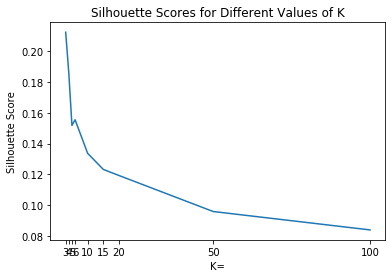

In [125]:
plt.plot(k_values, silhouette_scores)
plt.xticks(k_values)
plt.title("Silhouette Scores for Different Values of K")
plt.ylabel("Silhouette Score")
plt.xlabel("K=")
plt.show()

#### Elbow Plot: Calinski Harabaz Scores

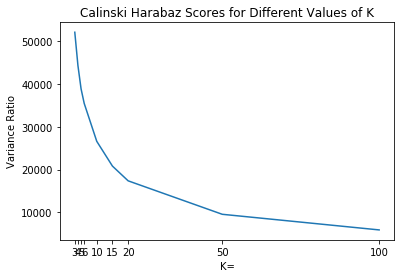

In [126]:
plt.plot(k_values, calinski_harabasz_scores)
plt.xticks(k_values)
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

## BIC

https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6

## Pipeline

In [ ]:
# Pipeline + GridSearchCV Example

# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=10)),
                ('svm', svm.SVC(random_state=123))])

# Create the grid parameter
grid = [{'svm__kernel': ['poly', 'sigmoid'],
         'svm__C': [0.01, 1, 100],
         'svm__degree0': [2,3,4,5],
         'svm__gamma': [0.001, 0.01]}]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)